In [73]:
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
from statistics import median
import pandas as pd
import glob
import os
import nest_asyncio
# import gspread
nest_asyncio.apply()
from tardis_dev import datasets
from scipy.optimize import curve_fit

In [74]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [75]:
datasets.download(
exchange="coinbase",
data_types=[
    "quotes"],
from_date = '2022-11-09',
to_date = '2022-11-10',
symbols = ["MATIC-USD"],
download_dir = r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase\MATICUSD",
api_key= "TD.CTo-GFKD9yJojKmk.0fsYIehJ-wDD1e-.FVe4814H5x7BkM7.uRoxlXUJQmcdRPz.HWyzjjLu4LiqBi4.sF6W",
)

datasets.download(
exchange="coinbase",
data_types=[
    "trades"],
from_date = '2022-11-09',
to_date = '2022-11-10',
symbols = ["MATIC-USD"],
download_dir = r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase\MATICUSD",
api_key= "TD.CTo-GFKD9yJojKmk.0fsYIehJ-wDD1e-.FVe4814H5x7BkM7.uRoxlXUJQmcdRPz.HWyzjjLu4LiqBi4.sF6W",
)

In [76]:
datasets.download(
exchange="coinbase",
data_types=[
    "book_snapshot_25"],
from_date = '2022-11-09',
to_date = '2022-11-10',
symbols = ["MATIC-USD"],
download_dir = r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase\MATICUSD",
api_key= "TD.CTo-GFKD9yJojKmk.0fsYIehJ-wDD1e-.FVe4814H5x7BkM7.uRoxlXUJQmcdRPz.HWyzjjLu4LiqBi4.sF6W",
)

In [77]:
quote_database = glob.glob(os.path.join(r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase\MATICUSD", "coinbase_quotes*" + "2022-11-09_MATIC-USD.csv.gz"))
df_quotes = pd.concat((pd.read_csv(f) for f in quote_database), ignore_index=True)
df_quotes['timestamp'] = pd.to_datetime(df_quotes.timestamp * 1000)
df_quotes['midprice'] = (df_quotes['ask_price'] + df_quotes['bid_price'])/2

orderbook_database =  glob.glob(os.path.join(r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase\MATICUSD", "coinbase_book_snapshot_25*" + "2022-11-09_MATIC-USD.csv.gz"))
df_orderbook = pd.concat((pd.read_csv(f) for f in orderbook_database), ignore_index=True)
df_orderbook['timestamp'] = pd.to_datetime(df_orderbook.timestamp * 1000)

trade_database = glob.glob(os.path.join(r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase\MATICUSD", "coinbase_trades*" + "2022-11-09_MATIC-USD.csv.gz"))
df_trades = pd.concat((pd.read_csv(f) for f in trade_database), ignore_index=True)
df_trades['timestamp'] = pd.to_datetime(df_trades.timestamp * 1000)
df_trades = df_trades[df_trades['timestamp'] >= df_quotes.loc[0, 'timestamp']]
df_trades.index = range(len(df_trades))

In [78]:
df_quotes['spread'] = df_quotes.ask_price - df_quotes.bid_price
df_quotes

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,midprice,spread
0,coinbase,MATIC-USD,2022-11-09 00:00:00.272714,1667952000272714,487.0,1.0445,1.0441,1338.6,1.04430,0.0004
1,coinbase,MATIC-USD,2022-11-09 00:00:00.215364,1667952000287484,487.0,1.0445,1.0441,178.9,1.04430,0.0004
2,coinbase,MATIC-USD,2022-11-09 00:00:00.235465,1667952000287736,487.0,1.0445,1.0441,781.3,1.04430,0.0004
3,coinbase,MATIC-USD,2022-11-09 00:00:00.242061,1667952000302110,487.0,1.0445,1.0441,178.9,1.04430,0.0004
4,coinbase,MATIC-USD,2022-11-09 00:00:00.248810,1667952000302472,1387.0,1.0445,1.0441,178.9,1.04430,0.0004
...,...,...,...,...,...,...,...,...,...,...
2798310,coinbase,MATIC-USD,2022-11-09 23:59:59.828347,1668038399878072,294.6,0.8152,0.8147,7460.7,0.81495,0.0005
2798311,coinbase,MATIC-USD,2022-11-09 23:59:59.853852,1668038399903804,1003.1,0.8151,0.8147,7460.7,0.81490,0.0004
2798312,coinbase,MATIC-USD,2022-11-09 23:59:59.855267,1668038399904705,1003.1,0.8151,0.8147,7057.0,0.81490,0.0004
2798313,coinbase,MATIC-USD,2022-11-09 23:59:59.855687,1668038399904736,1003.1,0.8151,0.8147,6137.2,0.81490,0.0004


In [79]:
df_trades = df_trades[0:1000]
df_trades.index = range(len(df_trades))

In [97]:
max_spread, min_spread = max(df_quotes.spread), min(df_quotes.spread)
gamma = 1
max_kappa, min_kappa = gamma / (np.exp(gamma * min_spread * 0.5) - 1), gamma / (np.exp(gamma * max_spread * 0.5) - 1)
print('Max spread: {},\ngamma: {},\nmax_kappa: {}.'.format(max_spread, gamma, max_kappa))
print('Min spread: {},\nmin_kappa: {}.'.format(min_spread, min_kappa))

Max spread: 0.015900000000000025,
gamma: 1,
max_kappa: 19999.500004156467.
Min spread: 9.999999999998899e-05,
min_kappa: 125.28682602131346.


In [81]:
def curve_fit_manual(x, y, alpha, kappa):
    def residuals(params):
        a = params[0]
        b = params[1]
        
        sum = 0
        for i in range(len(x)):
            sum += (y[i] - (a * np.exp(-b * x[i]))) ** 2
        return sum
    
    learning_rate = 0.01
    precision = 0.001
    
    a = alpha
    b = kappa
    da = 1
    db = 1
    
    time_start = datetime.datetime.now()
    
    while abs(da) > precision or abs(db) > precision:
        da = (residuals([a + precision, b]) - residuals([a, b])) / precision
        db = (residuals([a, b + precision]) - residuals([a, b])) / precision
        
        a -= learning_rate * da
        b -= learning_rate * db
        
        now = datetime.datetime.now()
        
        if (now - time_start).seconds > 1: 
            a = 0 
            b = 0
            
            break
            
        
    if a < 0: 
        a = 0 
    if b < 0: 
        b = 0
    
    return a, b

In [115]:
start_timestamp = df_quotes.loc[0, 'timestamp']

max_spread = max(df_quotes.spread)
alpha, kappa = 0, 0
prev_alpha, prev_kappa = 0,0

min_kappa = 951
min_alpha = 0

max_alpha = 50000000
#max_kappa = 1/(math.e**(max_spread / 2) - 1)

alphas, kappas = [], []
sampling_length = 30

for i in range(len(df_trades) - (sampling_length+30)):
    trade_samples = {}
    
    current_trade_sample = df_trades.loc[i:i+sampling_length+30][['timestamp', 'price', 'amount']]
    if i == 1:
        print(current_trade_sample)
    current_trade_sample.index = range(len(current_trade_sample))
    
    current_quote_sample = df_quotes[(df_quotes['timestamp'] >= start_timestamp) & 
                                    (df_quotes['timestamp'] < current_trade_sample.loc[len(current_trade_sample)-1, 'timestamp'])]
    
    
    #get price levels for each trade
    for j in range(len(current_trade_sample)):
        
        last_quote_df = df_quotes[df_quotes['timestamp'] < current_trade_sample.loc[j, 'timestamp']]
        last_quote_df.index = range(len(last_quote_df))
        
        #Get last quote price & timestamp
        last_quote_price = last_quote_df.loc[len(last_quote_df)-1, 'midprice']
        last_quote_timestamp = current_trade_sample.loc[j, 'timestamp']
        
        #last_quote_timestamp = last_quote_df.loc[len(last_quote_df)-1, 'timestamp']
        
        trade = {"price_level": round((abs(current_trade_sample.loc[j, 'price'] - float(last_quote_price))), 6), 
                 "amount": current_trade_sample.loc[j, 'amount']}
        
        if last_quote_timestamp not in trade_samples.keys():
            trade_samples[last_quote_timestamp] = []
        
        trade_samples[last_quote_timestamp] += [trade]
    

    if len(trade_samples.keys()) > sampling_length:
        timestamps = list(trade_samples.keys())
        timestamps.sort()
        timestamps = timestamps[:sampling_length]

        trade_samples_new = {}
        
        for timestamp in timestamps:
            trade_samples_new[timestamp] = trade_samples[timestamp]
            
        trade_samples = trade_samples_new
            
    
    ##We now have last 30 trades with price levels for each i
    
    # Calculate lambdas / trading intensities
    lambdas = []
    trades_consolidated = {} 
    price_levels = []

    for timestamp in trade_samples.keys():
        tick = trade_samples[timestamp]

        for trade in tick: 
            if trade['price_level'] not in trades_consolidated.keys():
                trades_consolidated[trade['price_level']] = 0
                price_levels += [trade['price_level']]
            
            trades_consolidated[trade['price_level']] += trade['amount']
    
    #UPDATE LAMBDAS
    for price_level in price_levels:
        lambdas += [trades_consolidated[price_level]]
        
    for price_level in trades_consolidated.copy():
        if trades_consolidated[price_level] < 100:
            del trades_consolidated[price_level]

    # Adjust to be able to calculate log
    lambdas_adj = [10**-10 if x==0 else x for x in lambdas]
    
    ##First assign previous alpha & kappa 
    alpha_fit, kappa_fit = curve_fit_manual(price_levels, lambdas_adj, 0, 0)
    
    alpha = max(min(max_alpha, alpha_fit), min_alpha)
    kappa = max(min(max_kappa, kappa_fit), min_kappa)
    
    alphas.append(alpha)
    kappas.append(kappa)
    
    if len(alphas) > 1:
        prev_alpha = alphas[-2]
        prev_kappa = kappas[-2]
    
    if (alpha == 0) and (prev_alpha != 0) and len(alphas) > 1: 
        alphas[-1] = prev_alpha
        alpha = 0
        
    if (kappa == 0) and (prev_kappa != 0) and len(kappas) > 1:
        kappas[-1] = prev_kappa
        kappa = 0
        
    if i % 1 == 0:
        print("Calculating ({}".format(np.round(100 * i / (len(df_trades) - (sampling_length+30)), 4)) + """%)""", end='\r')
    
    #Update start timestamp
    start_timestamp = current_trade_sample.loc[0, 'timestamp'] 

                    timestamp   price  amount
1  2022-11-09 00:00:01.903423  1.0444     9.5
2  2022-11-09 00:00:02.236086  1.0445   406.6
3  2022-11-09 00:00:03.048856  1.0447   770.7
4  2022-11-09 00:00:03.048856  1.0448   178.9
5  2022-11-09 00:00:03.048856  1.0448   417.3
..                        ...     ...     ...
57 2022-11-09 00:00:10.936958  1.0431   329.1
58 2022-11-09 00:00:10.936958  1.0431   233.8
59 2022-11-09 00:00:10.972669  1.0437   190.4
60 2022-11-09 00:00:11.496020  1.0436   233.8
61 2022-11-09 00:00:11.496020  1.0436   520.6

[61 rows x 3 columns]
     exchange     symbol                  timestamp   local_timestamp  \
24   coinbase  MATIC-USD 2022-11-09 00:00:00.948375  1667952000997658   
25   coinbase  MATIC-USD 2022-11-09 00:00:01.645329  1667952001694470   
26   coinbase  MATIC-USD 2022-11-09 00:00:01.660443  1667952001713049   
27   coinbase  MATIC-USD 2022-11-09 00:00:01.670928  1667952001720194   
28   coinbase  MATIC-USD 2022-11-09 00:00:01.708850  1667952

Traceback (most recent call last):
  File "C:\Users\Temp_Student_001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Temp_Student_001\AppData\Local\Temp\ipykernel_1908\3607431058.py", line 32, in <module>
    last_quote_df = df_quotes[df_quotes['timestamp'] < current_trade_sample.loc[j, 'timestamp']]
  File "C:\Users\Temp_Student_001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\common.py", line 72, in new_method
    return method(self, other)
  File "C:\Users\Temp_Student_001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py", line 50, in __lt__
    return self._cmp_method(other, operator.lt)
 

In [99]:
price_levels

[0.0002,
 5e-05,
 0.00035,
 0.00015,
 0.00025,
 0.00045,
 0.00055,
 0.0005,
 0.00065,
 0.0003,
 0.0004,
 0.0006,
 0.0007]

In [100]:
lambdas_adj

[980.2,
 249.8,
 1054.2,
 22.5,
 1203.8,
 541.2,
 179.79999999999998,
 4098.799999999999,
 153.4,
 2862.4,
 1287.1,
 818.0999999999999,
 1819.8000000000002]

In [101]:
trades_consolidated

{0.0002: 980.2,
 5e-05: 249.8,
 0.00035: 1054.2,
 0.00025: 1203.8,
 0.00045: 541.2,
 0.00055: 179.79999999999998,
 0.0005: 4098.799999999999,
 0.00065: 153.4,
 0.0003: 2862.4,
 0.0004: 1287.1,
 0.0006: 818.0999999999999,
 0.0007: 1819.8000000000002}

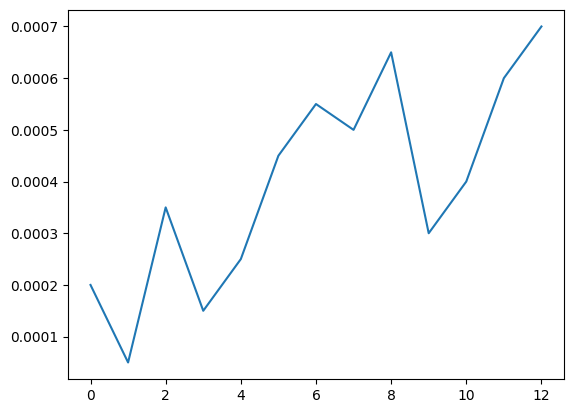

In [102]:
plt.plot(price_levels)

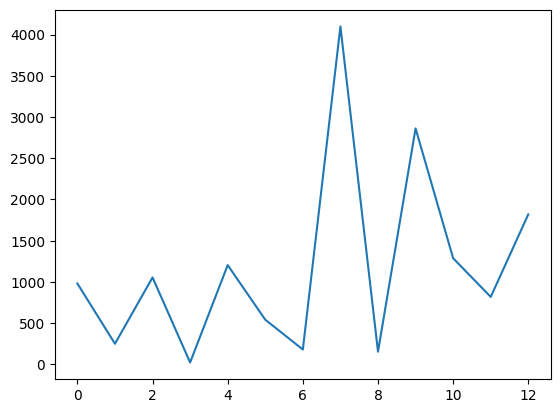

In [103]:
plt.plot(lambdas_adj)

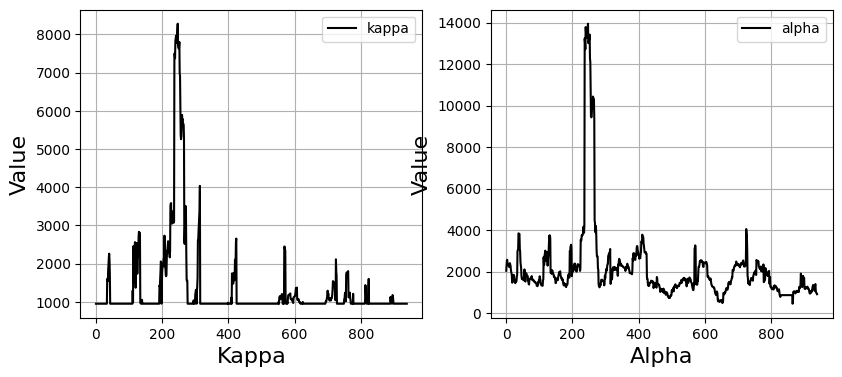

In [104]:
f = plt.figure(figsize=(15, 4))
f.add_subplot(1, 3, 1)
plt.plot(kappas, color='black', label='kappa')
plt.xlabel('Kappa', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1, 3, 2)
plt.plot(alphas, color='black', label='alpha')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.grid(True)
plt.legend()

In [105]:
def optimal_spread_stoikov(gamma, kappa):
    spread = (2/gamma)*math.log(1+ (gamma/kappa)) 
    return spread

def gueant_optimal_bids_asks(gamma, kappa, Q, alpha, sigma):
    coef = math.sqrt(((sigma**2 * gamma)/(2*kappa*alpha))*(1+(gamma/kappa))**(1+(kappa/gamma)))
    
    optimal_bid = (1/gamma)*math.log(1+(gamma/kappa)) + (1/2)*(2*Q +1)*coef
    
    optimal_ask = (1/gamma)*math.log(1+(gamma/kappa)) - (1/2)*(-2*Q - 1)*coef
    
    return optimal_bid + optimal_ask

In [106]:
for i in range(len(kappas)):
    if kappas[i] > 0:
        index_pos = i 
        break

In [107]:
index_pos

0

In [108]:
first_x_greeks = df_trades[30+index_pos:30+len(kappas)]['timestamp']
first_x_greeks.index = range(len(first_x_greeks))
first_x_greeks

0     2022-11-09 00:00:05.792098
1     2022-11-09 00:00:05.792141
2     2022-11-09 00:00:05.815410
3     2022-11-09 00:00:05.815410
4     2022-11-09 00:00:06.089675
                 ...            
935   2022-11-09 00:06:23.327158
936   2022-11-09 00:06:23.353652
937   2022-11-09 00:06:23.353652
938   2022-11-09 00:06:23.353652
939   2022-11-09 00:06:23.353652
Name: timestamp, Length: 940, dtype: datetime64[ns]

In [109]:
market_spread = []
level_5_spread = []
level_15_spread = []
level_20_spread = []

for i in range(len(first_x_greeks)):
    df_example = df_orderbook[df_orderbook['timestamp'] <= first_x_greeks[i]]
    idx = len(df_example) - 1
    
    spread_1 = df_example.loc[idx, 'asks[0].price'] - df_example.loc[idx, 'bids[0].price']
    market_spread.append(spread_1)
    
    spread_2 = df_example.loc[idx, 'asks[5].price'] - df_example.loc[idx, 'bids[5].price']
    level_5_spread.append(spread_2)
    
    spread_3 = df_example.loc[idx, 'asks[15].price'] - df_example.loc[idx, 'bids[15].price']
    level_15_spread.append(spread_3)

In [110]:
spreads_stoikov_1, spreads_stoikov_2, spreads_stoikov_3 = [], [], []
spreads_gueant_1, spreads_gueant_2, spreads_gueant_3 = [], [], []

gamma_1 = 0.01
gamma_2 = 0.1
gamma_3 = 0.99

for i in range(len(first_x_greeks)):
    spread_stoikov_1 = optimal_spread_stoikov(gamma_1/market_spread[i], kappas[i+index_pos])
    spread_gueant_1 = gueant_optimal_bids_asks(gamma_1/market_spread[i], kappas[i+index_pos], 0, alphas[i], 0.0002)
    
    spreads_stoikov_1.append(spread_stoikov_1)
    spreads_gueant_1.append(spread_gueant_1)
    
    spread_stoikov_2 = optimal_spread_stoikov(gamma_2/market_spread[i], kappas[i+index_pos])
    spread_gueant_2 = gueant_optimal_bids_asks(gamma_2/market_spread[i], kappas[i+index_pos], 0, alphas[i], 0.0002)
    
    spreads_stoikov_2.append(spread_stoikov_2)
    spreads_gueant_2.append(spread_gueant_2)
    
    spread_stoikov_3 = optimal_spread_stoikov(gamma_3/market_spread[i], kappas[i+index_pos])
    spread_gueant_3 = gueant_optimal_bids_asks(gamma_3/market_spread[i], kappas[i+index_pos], 0, alphas[i], 0.0002)
    
    spreads_stoikov_3.append(spread_stoikov_3)
    spreads_gueant_3.append(spread_gueant_3)

In [111]:
spreads_stoikov_4, spreads_stoikov_5, spreads_stoikov_6 = [], [], []

gamma_1 = 0.01
gamma_2 = 0.1
gamma_3 = 0.99

for i in range(len(first_x_greeks) - 7):
    spread_stoikov_4 = optimal_spread_stoikov(gamma_1, kappas[i+index_pos])
    spreads_stoikov_4.append(spread_stoikov_4)
    
    spread_stoikov_5 = optimal_spread_stoikov(gamma_2, kappas[i+index_pos])
    spreads_stoikov_5.append(spread_stoikov_5)
    
    spread_stoikov_6 = optimal_spread_stoikov(gamma_3, kappas[i+index_pos])
    spreads_stoikov_6.append(spread_stoikov_6)

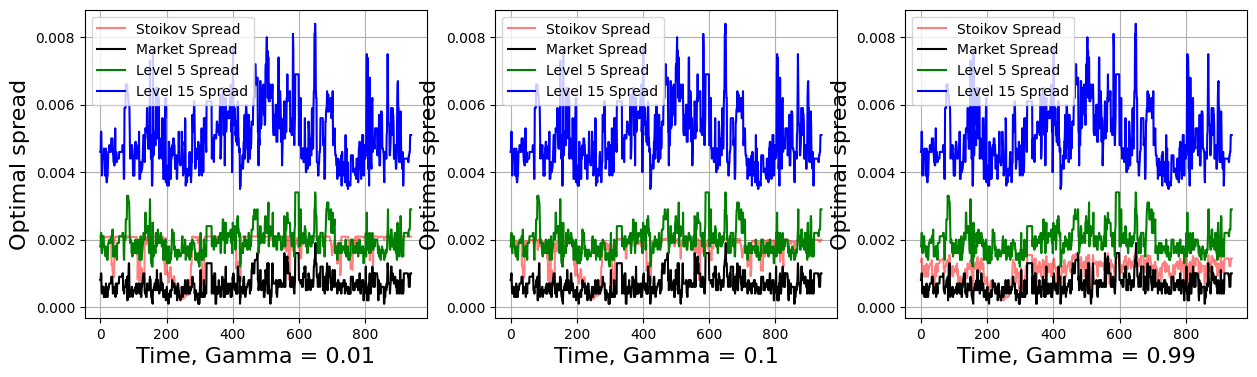

In [112]:
f = plt.figure(figsize=(15, 4))
f.add_subplot(1, 3, 1)
plt.plot(np.arange(0,len(spreads_stoikov_1),1), spreads_stoikov_1, color='red', label= 'Stoikov Spread', alpha = 0.5  )
#plt.plot(np.arange(0,len(spreads_stoikov_4),1), spreads_stoikov_4, color='blue', label= 'Stoikov Spread nd', alpha = 0.5  )
plt.plot(np.arange(0,len(market_spread),1), market_spread, color ='black', label= 'Market Spread' )
plt.plot(np.arange(0,len(level_5_spread),1), level_5_spread, color ='green', label= 'Level 5 Spread')
plt.plot(np.arange(0,len(level_15_spread),1), level_15_spread, color ='blue', label= 'Level 15 Spread')
plt.xlabel('Time, Gamma = {}'.format(gamma_1), fontsize=16)
plt.ylabel('Optimal spread', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1, 3, 2)
plt.plot(np.arange(0,len(spreads_stoikov_2),1), spreads_stoikov_2, color='red', label= 'Stoikov Spread', alpha = 0.5 )
#plt.plot(np.arange(0,len(spreads_stoikov_5),1), spreads_stoikov_5, color='blue', label= 'Stoikov Spread nd', alpha = 0.5 )
plt.plot(np.arange(0,len(market_spread),1), market_spread, color ='black', label= 'Market Spread' )
plt.plot(np.arange(0,len(level_5_spread),1), level_5_spread, color ='green', label= 'Level 5 Spread')
plt.plot(np.arange(0,len(level_15_spread),1), level_15_spread, color ='blue', label= 'Level 15 Spread')
plt.xlabel('Time, Gamma = {}'.format(gamma_2), fontsize=16)
plt.ylabel('Optimal spread', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1, 3, 3)
plt.plot(np.arange(0,len(spreads_stoikov_3), 1), spreads_stoikov_3, color='red', label= 'Stoikov Spread', alpha = 0.5 )
#plt.plot(np.arange(0,len(spreads_stoikov_6), 1), spreads_stoikov_6, color='blue', label= 'Stoikov Spread nd', alpha = 0.5 )
plt.plot(np.arange(0,len(market_spread), 1), market_spread, color ='black', label= 'Market Spread')
plt.plot(np.arange(0,len(level_5_spread),1), level_5_spread, color ='green', label= 'Level 5 Spread')
plt.plot(np.arange(0,len(level_15_spread),1), level_15_spread, color ='blue', label= 'Level 15 Spread')
plt.xlabel('Time, Gamma = {}'.format(gamma_3), fontsize=16)
plt.ylabel('Optimal spread', fontsize=16)
plt.grid(True)
plt.legend()

plt.savefig(r"C:\Users\Temp_Student_001\Desktop\research\0.projects\Ariyan\Dataset Coinbase MATIC")